### Load Factor Prediction Model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer


#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [4]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')

dataset['windgust'].replace(np.NaN, 0, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
dataset = dataset[dataset['loadFactor']<=1]
print(dataset['BMUID'].mode())
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)

print(y.mean())

print(dataset.describe())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=99)



0    ANSUW-1
dtype: object
(7297,)
(7297, 9)
0.31240393758872337
              temp      windspd     windgust  sealevelpressure   visibility  \
count  7297.000000  7297.000000  7297.000000       7297.000000  7297.000000   
mean      7.899644    11.281417    15.419131       1009.712073    19.261793   
std       4.779934     6.068177    19.399028         14.683884     8.283246   
min      -4.300000     0.000000     0.000000        952.700000     0.000000   
25%       4.200000     6.700000     0.000000       1000.200000    12.900000   
50%       7.500000    10.300000     6.000000       1010.700000    19.800000   
75%      11.700000    14.900000    29.800000       1019.200000    25.500000   
max      25.300000    49.000000   114.100000       1050.100000    46.600000   

        cloudcover       precip          dew     humidity   loadFactor  
count  7297.000000  7297.000000  7297.000000  7297.000000  7297.000000  
mean     56.368357     0.059309     4.970385    82.836943     0.312404  
std 

#### Approaches

##### Linear Regression

In [5]:
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

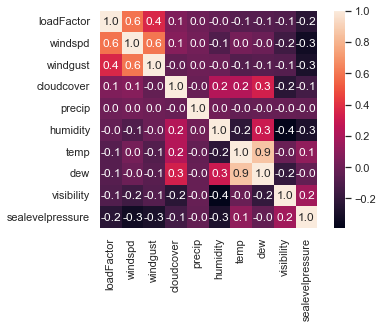

In [6]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True,
                      fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', LassoCV()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor()),
    ('SVM', SVR())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(
        steps=[('preprocessor', scaler), ('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor', DecisionTreeRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('GradBoost Regressor', GradientBoostingRegressor()),
    ('ADABoost Regressor', AdaBoostRegressor()),
    ('MLP Regressor', MLPRegressor()),
    ('XGBoost', xgb.XGBRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', Normalizer()),('preprocessor2', StandardScaler()), ('regressor', model)])
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold,)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


Linear Models:

Linear Regression: 0.363509 (0.065873)
Lasso: 0.363844 (0.064932)
ElasticNet: -0.007221 (0.009064)
SGDRegressor: 0.361618 (0.065059)
SVM: 0.402424 (0.075956)

Non-linear Models:

DecisionTree Regressor: -0.018678 (0.106475)
KNN Regressor: 0.349262 (0.042879)
GradBoost Regressor: 0.402793 (0.033812)
ADABoost Regressor: 0.338875 (0.047430)
MLP Regressor: 0.395887 (0.042880)
XGBoost: 0.372596 (0.033873)


Here we see some not ideal performance results and we find that when using our test dataset, the best scoring models (MLP,gradBoost) achieve roughly 0.18-19% mean error, and .14% standard deviation.


Using the tpot library we can search a range of different pipeline configurations to find the best option for our dataset. This includes evaluating NN options as well as different configurations of the SKlearn models tested at the start of this document

In [14]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=100, population_size=100, verbosity=2,scoring='neg_mean_absolute_error',n_jobs=-1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

tpot.export('tpot_exported_pipeline.py')

                                                                                 
Generation 1 - Current best internal CV score: -0.17309726885015075
                                                                                 
Generation 2 - Current best internal CV score: -0.17309726885015075
                                                                                 
Generation 3 - Current best internal CV score: -0.17309726885015075
                                                                                 
Generation 4 - Current best internal CV score: -0.1722979888245307
                                                                                 
Generation 5 - Current best internal CV score: -0.1722979888245307
                                                                                  
Generation 6 - Current best internal CV score: -0.16953037182220318
                                                                                 
Generation 7 - Curr